
**Aplicaremos la arquitectura PixToPix**

Citas. En este notebook vamos a intentar aplicar el paper https://arxiv.org/abs/1611.07004
esta implementado en keras en el siguiente github https://github.com/eriklindernoren/Keras-GAN/blob/master/pix2pix/pix2pix.py

En este momento, estamos estudiando si es posible completar el TFM , asi que voy a usar la implementación disponible en el git mencionado.

Recordemos, en los notebooks anteriores, hemos conseguido nuestros trazos del coche que simulan un coche dibujado manualmente ademas hemos echo nuestro augmentador y generador random de imagenes

Ahora lo que queremos es saber si aplicando algunas de las arquitecturas conocidas somos capaces de reconstruir in coche solo mediante sus trazos.

Aqui algunas de las arquitecturas disponibles

* DiscoGAN
* SuperResolution
* PixToPix
* CycleGAN


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))

import numpy as np
import pandas as pd
import os
from skimage.transform import resize
from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img
from skimage.io import imread, imshow #, concatenate_images
import PIL 
from PIL import Image
import re

['manualdraw', 'carvana-image-masking-challenge']


Using TensorFlow backend.


In [2]:
!mkdir images
#!ls -l '../input/train'

Preparamos unas cuantas funciones para leer del directorio

In [3]:
def files_names_in_path(path="",extension=".jpg"):
    files = []
    masks = []
    for f in os.listdir(path):
        filename, file_extension = os.path.splitext(f)
        if file_extension == '.gif':
            files.append(filename.replace('_mask','')+".jpg")
            masks.append(filename+"_mask.gif")
            
    return files, masks
car_path = '../input/carvana-image-masking-challenge/train/'
mask_path = '../input/carvana-image-masking-challenge/train_masks/'
input_files,input_masks = files_names_in_path(mask_path)

print(input_files[0:5])


['4b74275babf7_02.jpg', '3071362591f7_04.jpg', '0495dcf27283_10.jpg', 'd1a3af34e674_01.jpg', 'fc237174b128_09.jpg']


[[[0.95686275 0.95294118 0.97254902]
  [0.95686275 0.95294118 0.97254902]
  [0.95686275 0.95294118 0.97254902]
  ...
  [0.91764706 0.90196078 0.90588235]
  [0.91764706 0.90196078 0.90588235]
  [0.91764706 0.90196078 0.90588235]]

 [[0.95686275 0.95294118 0.97254902]
  [0.95686275 0.95294118 0.97254902]
  [0.95686275 0.95294118 0.97254902]
  ...
  [0.91764706 0.90196078 0.90588235]
  [0.91764706 0.90196078 0.90588235]
  [0.91764706 0.90196078 0.90588235]]

 [[0.95686275 0.95294118 0.97254902]
  [0.95686275 0.95294118 0.97254902]
  [0.95686275 0.95294118 0.97254902]
  ...
  [0.91764706 0.90196078 0.90588235]
  [0.91764706 0.90196078 0.90588235]
  [0.91764706 0.90196078 0.90588235]]

 ...

 [[0.83137255 0.83137255 0.82352941]
  [0.83137255 0.83137255 0.82352941]
  [0.83137255 0.83137255 0.82352941]
  ...
  [0.92941176 0.91372549 0.91764706]
  [0.92941176 0.91372549 0.91764706]
  [0.92941176 0.91372549 0.91764706]]

 [[0.83137255 0.83137255 0.82352941]
  [0.83137255 0.83137255 0.82352941]


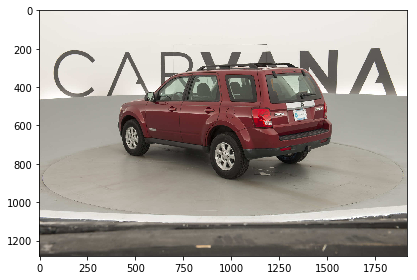

In [4]:
def load_image_and_normalize_and_resize(file_path="",normalize=True):
    if normalize:
        return (imread(file_path)/255)
    else:
        return (imread(file_path))
    

print(load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,1)[0]))
print(imshow(load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,2)[0])))
print(load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,1)[0]).shape)
HEIGH = load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,1)[0]).shape[0]
WIDTH = load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,1)[0]).shape[1]

In [5]:
mask = pd.read_csv('../input/carvana-image-masking-challenge/train_masks.csv')

In [6]:
len(mask)

5088

In [7]:
# ignore this function not needed finally... reference https://www.kaggle.com/robertkag/rle-to-mask-converter finally not used but i like this function i saved..

import numpy as np # linear algebra
#(1280, 1918, 3)

def rleToMask(rleString,height,width):
    rows, cols = height,width
    rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
    rlePairs = np.array(rleNumbers).reshape(-1,2)
    img = np.zeros(rows*cols,dtype=np.uint8)
    for index,length in rlePairs:
        index -= 1
        img[index:index+length] = 255
    img = img.reshape(cols,rows)
    img = img.T
    return img

In [8]:
#index=3
#temp_mask = rleToMask(mask['rle_mask'][3],WIDTH,HEIGH)
#print(temp_mask.shape)
#rotated_mask = np.rot90(np.rot90(np.rot90(temp_mask)))
#imshow(rotated_mask)


In [9]:
# empezamos a trabajar para obtener la mascara del coche solo nos interesa el coche para mejorar el performanc
# ademas queremos simular los trazos humanos extrayendo los edges del coche (pero solo del coche, el fondo no nos interesa)
import cv2
indx=5000
carimage = car_path+input_files[indx]
maskimage = mask_path+input_files[indx].replace('.jpg','_mask.gif')

print(carimage)
print(maskimage)
img = cv2.imread(carimage)
#mask = cv2.imread(maskimage)
mask=imread(maskimage)
print(mask)

# get first masked value (foreground)
fg = cv2.bitwise_or(img, img, mask=mask)
# get second masked value (background) mask must be inverted
mask = cv2.bitwise_not(mask)
background = np.full(img.shape, 255, dtype=np.uint8)
bk = cv2.bitwise_or(background, background, mask=mask)

# combine foreground+background
final = cv2.bitwise_or(fg, bk)

../input/carvana-image-masking-challenge/train/fff9b3a5373f_12.jpg
../input/carvana-image-masking-challenge/train_masks/fff9b3a5373f_12_mask.gif
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Bien hay que tener presente el objetivo, el objetivo final es usar la liberia OpenCv, en concreto el alghotirmo de CanyEdge detection, que nos permite resaltar y extraer contornos de una imagen, esta imagen va a suer nuestros inputs en las GAN, es decir seremos capaz de reconstruir un coche solamente conociendo su contorno?
Para ellos i conociendo a priori el Canny Edge detection, va a funcionar mejor si somos capaces de extraer de la imagen completa unicamente los elementos que nos interesan, es decir solo el coche

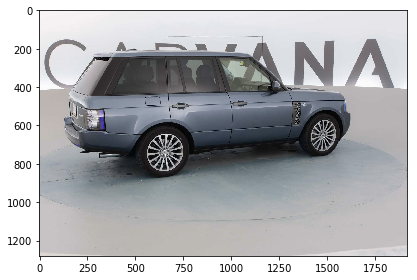

In [10]:
#La imagen original
imshow(img)

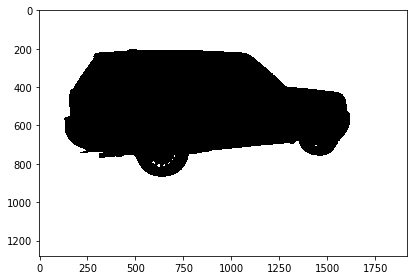

In [11]:
#La mascara
imshow(mask)

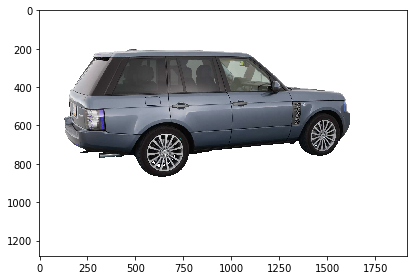

In [12]:
#La imagen del coche aplicando la mascara
# BIEN!!! ahora vamos a intentar extraer los contornos!!
imshow(final)

# Empezamos con un ejemplo basico de la pagina de OpenCV

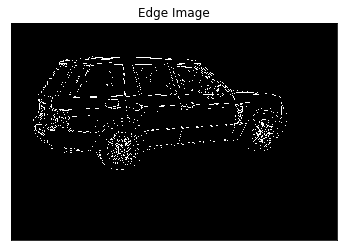

In [13]:

import cv2
import numpy as np
from matplotlib import pyplot as plt

img = final
edges = cv2.Canny(img,50,100)

#plt.subplot(121),
plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
#plt.subplot(122),
plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()
#La aproximación no es muy buena necessitamos las lineas del contorno

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


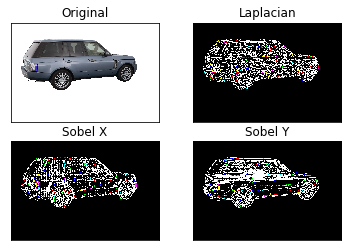

In [14]:
# Usamos otro ejemplo de la pagina OpenCV
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = final

laplacian = cv2.Laplacian(img,cv2.CV_64F)
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()

Estabamos por buen camino, antes de applicar el cannyedge detection tal como explica en la doc de OpenCV, antes se debia de corregir las imagenes aplicando GaussianBlur i erode para cerrar gaps
Adjunto fuentes de información
#https://stackoverflow.com/questions/21104664/extract-all-bounding-boxes-using-opencv-python/21108680
#https://stackoverflow.com/questions/13887863/extract-bounding-box-and-save-it-as-an-image
#https://www.kaggle.com/ayalamann/bounding-boxes-using-image-processing
#https://cvisiondemy.com/extract-roi-from-image-with-python-and-opencv/

(1280, 1918)


255

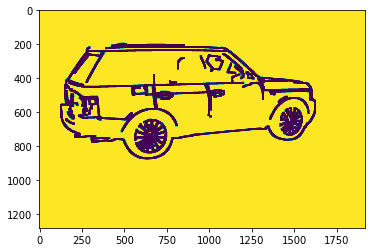

In [15]:
def get_edge_v2(img):
    blurred = cv2.GaussianBlur(img, (7,7), 0) # Remove noise
    #close the small line gaps using errosion
    kernel = np.ones((3,3), np.uint8)
    erode = cv2.erode(blurred, kernel, iterations = 3)
    #plt.imshow(erode)
    #cannyedge 
    def canny_edge_detector(input_img, threshold1, threshold2, draw=True, save=True):
        canny_img = cv2.cvtColor(np.copy(input_img), cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(canny_img, threshold1, threshold2)
        return edges
    #try adding Eroding before edge detection(increase black lines)
    canny_edges = canny_edge_detector(input_img=erode, threshold1=100, threshold2=150) 
    #return np.invert(canny_edges)#return np.invert(canny_edges)
    #plt.imshow(canny_edges)

    #close the small line gaps using dilation
    kernel = np.ones((5,5), np.uint8)
    dilation_canny = cv2.dilate(canny_edges, kernel, iterations = 3)
    canny_blurred = cv2.GaussianBlur(dilation_canny, (3,3), 0) # Remove noise
    #invetimos la mascara queremos el blanco de fondo y el negro como dibujo del coche
    return np.invert(canny_blurred)
ret =get_edge_v2(final)
plt.imshow(ret)
print(ret.shape)
np.max(ret)


Es Fantastico!!! con esto podemos seguir adelante con el TFM!!! Nos preparamos una función get edges random que usaremos en los data augmentation!

In [16]:
def get_edge_v2_randoms(img):
    choise=[3,5,7]
    x = np.random.choice(choise,1)
    
    blurred = cv2.GaussianBlur(img, (x,x), 0) # Remove noise
    #close the small line gaps using errosion
    x = np.random.randint(2,5)
    kernel = np.ones((x,x), np.uint8)
    x = np.random.randint(2,5)
    erode = cv2.erode(blurred, kernel, iterations = x)
    # plt.imshow(erode)
    #cannyedge 
    def canny_edge_detector(input_img, threshold1, threshold2, draw=True, save=True):
        canny_img = cv2.cvtColor(np.copy(input_img), cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(canny_img, threshold1, threshold2)
        return edges
    #try adding Eroding before edge detection(increase black lines)
    x = np.random.randint(80,125)
    y = np.random.randint(135,180)
    canny_edges = canny_edge_detector(input_img=erode, threshold1=100, threshold2=150) 
    #return np.invert(canny_edges)
    # plt.imshow(canny_edges)

    #close the small line gaps using dilation
    x = np.random.randint(2,5)
    kernel = np.ones((x,x), np.uint8)
    x = np.random.randint(2,5)
    dilation_canny = cv2.dilate(canny_edges, kernel, iterations = x)
    
    x = np.random.choice(choise,1)
    canny_blurred = cv2.GaussianBlur(dilation_canny, (x,x), 0) # Remove noise
    return np.invert(canny_blurred)


(1280, 1918)


255

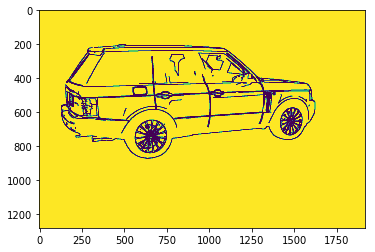

In [17]:
ret =get_edge_v2_randoms(final)
plt.imshow(ret)
print(ret.shape)
np.max(ret)

AxesImage(38.5601,27.8;382.64x245.485)


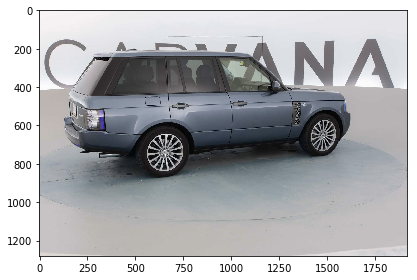

In [18]:
print(imshow(cv2.imread(carimage)))

In [19]:
from sklearn.model_selection import train_test_split
train_input, test_input, _, _ = train_test_split(input_files, input_files, test_size=0.15, random_state=42)
print(len(train_input))
print(len(test_input))

4324
764


Para augmentar las imagenes, vamos a usar la liberia conocida "imgaug", en siguiente kernels intentaremos desarrollar nuestros porpios augmentadores, trabajando con la numpy directamente.. pero esta liberia nos permite hacer una augmentación de manera muy rapida

In [20]:
from imgaug import augmenters as iaa
import imgaug as ia
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential([
    iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    # iaa.GaussianBlur(sigma=(0, 3.0)), # blur images with a sigma of 0 to 3.0
    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1))),
    sometimes(iaa.Affine(
            scale={"x": (1, 1.2), "y": (1, 1.2)}, # scale images to 80-120% of their size, individually per axis
            #translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            #rotate=(-45, 45), # rotate by -45 to +45 degrees
            #shear=(-16, 16), # shear by -16 to +16 degrees
            #order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            #cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ))
])

Preparamos nuestra funciones de utilidad para nuestro augmentador

In [21]:
import skimage
BATCH_SIZE=32

def get_clean_image(path,path_mask):    
    img = cv2.imread(path)
    # img = cv2.resize(img, (h, w))
    # print(imshow(img))
    #mask = cv2.imread(maskimage)
    mask=np.int8((imread(path_mask)))
    # print(mask)   
    # get first masked value (foreground)
    fg = cv2.bitwise_or(img, img, mask=mask)
    # get second masked value (background) mask must be inverted
    mask = cv2.bitwise_not(mask)
    background = np.full(img.shape, 255, dtype=np.uint8)
    bk = cv2.bitwise_or(background, background, mask=mask)

    # combine foreground+background
    final = cv2.bitwise_or(fg, bk)

    return final

def generator_int(path, batch_size=BATCH_SIZE, normalize=True, augmented=True):
    
    #retedge = np.zeros((batch_size,H,W,3),dtype=np.int16)
    #retimg = np.zeros((batch_size,H,W,3),dtype=np.int16)
    retedge = []
    retimg = []
    imgorig=[]
    for x in range(batch_size):
        car = np.random.choice(path,1)[0]
        carpath = car_path+car
        maskpath = mask_path+car.replace('.jpg','_mask.gif')
        #print(maskpath)
        img =  get_clean_image(carpath, maskpath)
        retimg.append(img)
        #mask = get_edge_v2(retimg[x])
        #mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
        #retedge.append(mask)
 #       retimg[x] = img
        #imgorig = img
        # print(retimg[x].shape)
        #print(np.max(retimg[x]))
        #mask = get_edge_v2(img)
        
        # mask = skimage.color.gray2rgb(mask.reshape(H,W,1))
        #print(mask.shape)
        #retedge[x] = mask
    #augmented images
    if augmented:
        retimg = seq.augment_images(np.array(retimg))
    else:
        retimg = np.array(retimg)
    #for x in range(batch_size):
#        imgorig.append(retimg[x])
    #
    for x in range(batch_size):
        #print(x)
        mask = get_edge_v2(retimg[x])
        mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
        retedge.append(mask)
        
    
    #if normalize:
#        retimg = retimg/255
       # retedge = retedge/255
    return np.array(retedge), np.array(retimg)

In [22]:
indx=500
carimage = car_path+input_files[indx]
maskimage = mask_path+input_files[indx].replace('.jpg','_mask.gif')
# img = get_clean_image(carimage, maskimage)
A,B = generator_int(train_input,1,False)
B.shape

(1, 1280, 1918, 3)

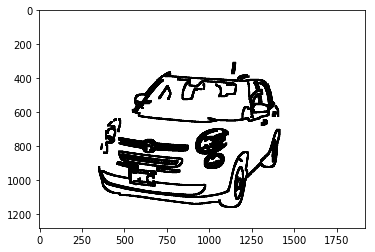

In [23]:
plt.imshow(A[0])


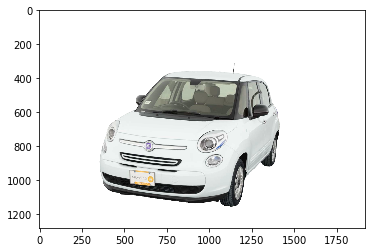

In [24]:
plt.imshow(B[0])

In [25]:
def downsample(img, h, w):    
    # ret = resize(img, (h, w), mode='constant', preserve_range=True)
    # plt.imshow(ret)
    return cv2.resize(img, (h, w))

def generator_resize(path="", batch_size=BATCH_SIZE, normalize=True, h=256, w=256, augmented=True):
    a,b = generator_int(path,batch_size,False, augmented)
    
    #resize image
    newA=[]
    newB=[]
    for x in range(batch_size):
        newA.append(downsample(a[x],h,w))
        newB.append(downsample(b[x],h,w))

    return np.array(newA), np.array(newB)

In [26]:
H = 256
W = 256
A, B = generator_resize(train_input,1, False, H,W)
A.shape

(1, 256, 256, 3)

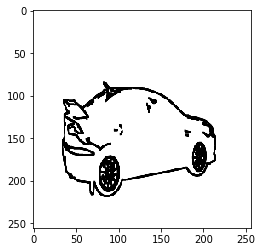

In [27]:
plt.imshow(A[0])

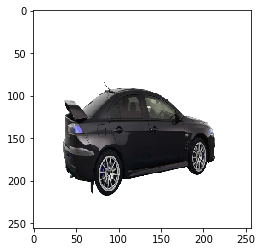

In [28]:
plt.imshow(B[0])

In [29]:
#Conseguido, tenemos un generador que aplica augmentacion a las imagenes y a las mascaras

In [30]:
from __future__ import print_function, division
import scipy

from keras.datasets import mnist

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys

import numpy as np
import os

class Pix2Pix():
    def __init__(self):
        # Input shape
        self.img_rows = H
        self.img_cols = W
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.dataset_name = 'carsdrawpixtopix'


        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 64
        self.df = 64

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generator
        #-------------------------

        # Build the generator
        self.generator = self.build_generator()

        # Input images and their conditioning images
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # By conditioning on B generate a fake version of A
        fake_A = self.generator(img_B)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Discriminators determines validity of translated images / condition pairs
        valid = self.discriminator([fake_A, img_B])

        self.combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
        self.combined.compile(loss=['mse', 'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf, bn=False)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)
        d5 = conv2d(d4, self.gf*8)
        d6 = conv2d(d5, self.gf*8)
        d7 = conv2d(d6, self.gf*8)

        # Upsampling
        u1 = deconv2d(d7, d6, self.gf*8)
        u2 = deconv2d(u1, d5, self.gf*8)
        u3 = deconv2d(u2, d4, self.gf*8)
        u4 = deconv2d(u3, d3, self.gf*4)
        u5 = deconv2d(u4, d2, self.gf*2)
        u6 = deconv2d(u5, d1, self.gf)

        u7 = UpSampling2D(size=2)(u6)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = Concatenate(axis=-1)([img_A, img_B])

        d1 = d_layer(combined_imgs, self.df, bn=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model([img_A, img_B], validity)

    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            for batch_i in range(batch_size): 
                #in enumerate(self.data_loader.load_batch(batch_size)):

                imgs_B, imgs_A =  generator_resize(train_input,batch_size, False, H,W,True)
                #generator(train_input,batch_size,False)
                
                imgs_A = (imgs_A/127.5)-1
                imgs_B = (imgs_B/127.5)-1

    #        for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Condition on B and generate a translated version
                fake_A = self.generator.predict(imgs_B)

                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = self.discriminator.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = self.discriminator.train_on_batch([fake_A, imgs_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # -----------------
                #  Train Generator
                # -----------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])

                elapsed_time = datetime.datetime.now() - start_time
                # Plot the progress
                print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch, epochs,
                                                                        batch_i, batch_size,
                                                                        d_loss[0], 100*d_loss[1],
                                                                        g_loss[0],
                                                                        elapsed_time))

                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)

    def sample_images(self, epoch, batch_i):
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        r, c = 3, 3

        imgs_B, imgs_A =  generator_resize(train_input,3, False, H,W,True)
                #generator(train_input,batch_size,False)
                
        imgs_A = (imgs_A/127.5)-1
        imgs_B = (imgs_B/127.5)-1

#        imgs_A, imgs_B = self.data_loader.load_data(batch_size=3, is_testing=True)
        fake_A = self.generator.predict(imgs_B)

        gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Condition', 'Generated', 'Original']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i))
        plt.close()




#############################################################



In [31]:
pixgan = Pix2Pix()
pixgan.train(epochs=100, batch_size=16, sample_interval=10)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[Epoch 0/100] [Batch 0/16] [D loss: 5.169256, acc:  11%] [G loss: 99.673805] time: 0:00:15.143472
[Epoch 0/100] [Batch 1/16] [D loss: 26.938251, acc:  14%] [G loss: 64.502625] time: 0:00:19.917112
[Epoch 0/100] [Batch 2/16] [D loss: 8.556006, acc:   8%] [G loss: 57.649254] time: 0:00:23.861895
[Epoch 0/100] [Batch 3/16] [D loss: 2.958130, acc:  15%] [G loss: 44.281044] time: 0:00:27.571643
[Epoch 0/100] [Batch 4/16] [D loss: 1.850834, acc:  38%] [G loss: 39.829460] time: 0:00:31.522890
[Epoch 0/100] [Batch 5/16] [D loss: 1.135885, acc:  40%] [G loss: 36.275532] time: 0:00:35.333123
[Epoch 0/100] [Batch 6/16] [D loss: 0.805933, acc:  38%] [G loss: 35.662029] time: 0:00:39.222945
[Epoch 0/100] [Batch 7/16] [D loss: 0.731152, acc:  45%] [G loss: 32.743687] time: 0:00:43.122664
[Epoch 0/100] [Batch 8/16] [D loss: 0.698444, acc:  44%] [G loss: 33.780415] time: 0:00:46.884748
[Epoch 0/100] [Batch 9/16] [D loss: 0.691081, acc:  51%] [G loss: 31.039183] time: 0:00:50.895345
[Epoch 0/100] [Batc

[Epoch 5/100] [Batch 4/16] [D loss: 0.316441, acc:  48%] [G loss: 11.858243] time: 0:05:48.157684
[Epoch 5/100] [Batch 5/16] [D loss: 0.325330, acc:  46%] [G loss: 13.895043] time: 0:05:51.869527
[Epoch 5/100] [Batch 6/16] [D loss: 0.297758, acc:  49%] [G loss: 14.585563] time: 0:05:55.523834
[Epoch 5/100] [Batch 7/16] [D loss: 0.320106, acc:  44%] [G loss: 14.880031] time: 0:05:59.139579
[Epoch 5/100] [Batch 8/16] [D loss: 0.288131, acc:  59%] [G loss: 13.103128] time: 0:06:02.870915
[Epoch 5/100] [Batch 9/16] [D loss: 0.309961, acc:  46%] [G loss: 12.559352] time: 0:06:06.707990
[Epoch 5/100] [Batch 10/16] [D loss: 0.273251, acc:  63%] [G loss: 11.858549] time: 0:06:10.442704
[Epoch 5/100] [Batch 11/16] [D loss: 0.197982, acc:  73%] [G loss: 16.035049] time: 0:06:14.890773
[Epoch 5/100] [Batch 12/16] [D loss: 0.381895, acc:  29%] [G loss: 12.210906] time: 0:06:18.505265
[Epoch 5/100] [Batch 13/16] [D loss: 0.279886, acc:  41%] [G loss: 12.283189] time: 0:06:22.128290
[Epoch 5/100] [B

[Epoch 10/100] [Batch 8/16] [D loss: 0.163898, acc:  80%] [G loss: 11.071718] time: 0:11:14.903426
[Epoch 10/100] [Batch 9/16] [D loss: 0.313659, acc:  48%] [G loss: 11.858922] time: 0:11:18.567396
[Epoch 10/100] [Batch 10/16] [D loss: 0.320215, acc:  43%] [G loss: 10.869816] time: 0:11:22.001460
[Epoch 10/100] [Batch 11/16] [D loss: 0.372842, acc:  52%] [G loss: 10.626783] time: 0:11:26.154511
[Epoch 10/100] [Batch 12/16] [D loss: 0.355535, acc:  56%] [G loss: 9.196617] time: 0:11:29.603606
[Epoch 10/100] [Batch 13/16] [D loss: 0.338605, acc:  57%] [G loss: 10.720249] time: 0:11:33.254956
[Epoch 10/100] [Batch 14/16] [D loss: 0.337120, acc:  59%] [G loss: 10.497581] time: 0:11:37.088381
[Epoch 10/100] [Batch 15/16] [D loss: 0.314748, acc:  63%] [G loss: 11.590209] time: 0:11:40.868941
[Epoch 11/100] [Batch 0/16] [D loss: 0.304248, acc:  66%] [G loss: 10.951638] time: 0:11:44.435059
[Epoch 11/100] [Batch 1/16] [D loss: 0.330005, acc:  62%] [G loss: 11.679838] time: 0:11:48.739435
[Epoc

[Epoch 15/100] [Batch 11/16] [D loss: 0.305232, acc:  57%] [G loss: 8.788642] time: 0:16:35.554902
[Epoch 15/100] [Batch 12/16] [D loss: 0.308412, acc:  57%] [G loss: 9.607327] time: 0:16:39.156188
[Epoch 15/100] [Batch 13/16] [D loss: 0.327394, acc:  58%] [G loss: 11.848266] time: 0:16:42.846436
[Epoch 15/100] [Batch 14/16] [D loss: 0.358417, acc:  64%] [G loss: 16.184982] time: 0:16:46.750164
[Epoch 15/100] [Batch 15/16] [D loss: 0.272019, acc:  72%] [G loss: 12.209251] time: 0:16:50.577924
[Epoch 16/100] [Batch 0/16] [D loss: 0.147375, acc:  85%] [G loss: 9.143566] time: 0:16:54.216752
[Epoch 16/100] [Batch 1/16] [D loss: 0.406107, acc:  43%] [G loss: 10.218691] time: 0:16:58.477424
[Epoch 16/100] [Batch 2/16] [D loss: 0.587780, acc:  26%] [G loss: 10.386498] time: 0:17:02.259576
[Epoch 16/100] [Batch 3/16] [D loss: 0.401721, acc:  30%] [G loss: 10.793376] time: 0:17:06.154175
[Epoch 16/100] [Batch 4/16] [D loss: 0.238296, acc:  64%] [G loss: 11.572554] time: 0:17:09.700456
[Epoch 1

[Epoch 20/100] [Batch 14/16] [D loss: 0.182930, acc:  74%] [G loss: 9.404770] time: 0:21:56.616663
[Epoch 20/100] [Batch 15/16] [D loss: 0.325785, acc:  43%] [G loss: 10.563656] time: 0:22:00.545297
[Epoch 21/100] [Batch 0/16] [D loss: 0.323073, acc:  40%] [G loss: 7.993617] time: 0:22:04.248158
[Epoch 21/100] [Batch 1/16] [D loss: 0.240122, acc:  50%] [G loss: 9.092342] time: 0:22:08.970070
[Epoch 21/100] [Batch 2/16] [D loss: 0.230517, acc:  70%] [G loss: 10.796384] time: 0:22:13.101791
[Epoch 21/100] [Batch 3/16] [D loss: 0.316082, acc:  51%] [G loss: 9.842743] time: 0:22:17.174170
[Epoch 21/100] [Batch 4/16] [D loss: 0.403402, acc:  48%] [G loss: 15.043186] time: 0:22:21.175410
[Epoch 21/100] [Batch 5/16] [D loss: 0.330943, acc:  60%] [G loss: 12.462584] time: 0:22:25.094358
[Epoch 21/100] [Batch 6/16] [D loss: 0.195724, acc:  77%] [G loss: 9.269217] time: 0:22:29.070829
[Epoch 21/100] [Batch 7/16] [D loss: 0.143017, acc:  84%] [G loss: 9.462074] time: 0:22:33.018729
[Epoch 21/100]

[Epoch 26/100] [Batch 2/16] [D loss: 0.245026, acc:  73%] [G loss: 8.915854] time: 0:27:30.570437
[Epoch 26/100] [Batch 3/16] [D loss: 0.126245, acc:  87%] [G loss: 7.693604] time: 0:27:34.306527
[Epoch 26/100] [Batch 4/16] [D loss: 0.129766, acc:  86%] [G loss: 8.255348] time: 0:27:37.960462
[Epoch 26/100] [Batch 5/16] [D loss: 0.281095, acc:  48%] [G loss: 7.881343] time: 0:27:41.603906
[Epoch 26/100] [Batch 6/16] [D loss: 0.267677, acc:  49%] [G loss: 9.002264] time: 0:27:45.347275
[Epoch 26/100] [Batch 7/16] [D loss: 0.268627, acc:  59%] [G loss: 7.582291] time: 0:27:49.114592
[Epoch 26/100] [Batch 8/16] [D loss: 0.283549, acc:  52%] [G loss: 7.874019] time: 0:27:52.886175
[Epoch 26/100] [Batch 9/16] [D loss: 0.295778, acc:  64%] [G loss: 9.445625] time: 0:27:56.728182
[Epoch 26/100] [Batch 10/16] [D loss: 0.308224, acc:  64%] [G loss: 8.431498] time: 0:28:00.864016
[Epoch 26/100] [Batch 11/16] [D loss: 0.314714, acc:  65%] [G loss: 7.880024] time: 0:28:05.978313
[Epoch 26/100] [Ba

[Epoch 31/100] [Batch 6/16] [D loss: 0.189231, acc:  81%] [G loss: 8.610356] time: 0:33:02.816122
[Epoch 31/100] [Batch 7/16] [D loss: 0.145368, acc:  84%] [G loss: 7.732433] time: 0:33:06.607553
[Epoch 31/100] [Batch 8/16] [D loss: 0.349242, acc:  33%] [G loss: 7.367388] time: 0:33:10.332894
[Epoch 31/100] [Batch 9/16] [D loss: 0.410309, acc:  28%] [G loss: 7.851672] time: 0:33:13.955639
[Epoch 31/100] [Batch 10/16] [D loss: 0.326902, acc:  33%] [G loss: 7.521987] time: 0:33:17.817730
[Epoch 31/100] [Batch 11/16] [D loss: 0.275668, acc:  43%] [G loss: 8.656110] time: 0:33:22.712121
[Epoch 31/100] [Batch 12/16] [D loss: 0.305211, acc:  57%] [G loss: 8.350408] time: 0:33:27.106960
[Epoch 31/100] [Batch 13/16] [D loss: 0.307885, acc:  65%] [G loss: 7.856046] time: 0:33:31.280189
[Epoch 31/100] [Batch 14/16] [D loss: 0.328484, acc:  65%] [G loss: 9.352332] time: 0:33:35.418633
[Epoch 31/100] [Batch 15/16] [D loss: 0.352227, acc:  65%] [G loss: 8.342361] time: 0:33:39.546662
[Epoch 32/100]

[Epoch 36/100] [Batch 10/16] [D loss: 0.341729, acc:  66%] [G loss: 8.198540] time: 0:38:40.972826
[Epoch 36/100] [Batch 11/16] [D loss: 0.328007, acc:  63%] [G loss: 12.052990] time: 0:38:46.172221
[Epoch 36/100] [Batch 12/16] [D loss: 0.298407, acc:  68%] [G loss: 11.139147] time: 0:38:50.463300
[Epoch 36/100] [Batch 13/16] [D loss: 0.286854, acc:  64%] [G loss: 8.356957] time: 0:38:54.622162
[Epoch 36/100] [Batch 14/16] [D loss: 0.246877, acc:  68%] [G loss: 8.576511] time: 0:38:58.684776
[Epoch 36/100] [Batch 15/16] [D loss: 0.254862, acc:  53%] [G loss: 7.928527] time: 0:39:02.733232
[Epoch 37/100] [Batch 0/16] [D loss: 0.271558, acc:  48%] [G loss: 10.905400] time: 0:39:06.849748
[Epoch 37/100] [Batch 1/16] [D loss: 0.243601, acc:  53%] [G loss: 10.892927] time: 0:39:11.544224
[Epoch 37/100] [Batch 2/16] [D loss: 0.134038, acc:  82%] [G loss: 8.850818] time: 0:39:15.581732
[Epoch 37/100] [Batch 3/16] [D loss: 0.117763, acc:  91%] [G loss: 8.612702] time: 0:39:19.663978
[Epoch 37/

[Epoch 41/100] [Batch 14/16] [D loss: 0.268687, acc:  36%] [G loss: 7.761610] time: 0:44:23.869634
[Epoch 41/100] [Batch 15/16] [D loss: 0.273425, acc:  45%] [G loss: 8.289554] time: 0:44:27.739993
[Epoch 42/100] [Batch 0/16] [D loss: 0.294649, acc:  43%] [G loss: 7.412872] time: 0:44:31.595621
[Epoch 42/100] [Batch 1/16] [D loss: 0.305911, acc:  60%] [G loss: 7.610456] time: 0:44:36.135576
[Epoch 42/100] [Batch 2/16] [D loss: 0.343243, acc:  62%] [G loss: 7.726773] time: 0:44:39.728614
[Epoch 42/100] [Batch 3/16] [D loss: 0.339790, acc:  67%] [G loss: 8.088281] time: 0:44:43.373203
[Epoch 42/100] [Batch 4/16] [D loss: 0.335691, acc:  66%] [G loss: 7.393230] time: 0:44:47.378875
[Epoch 42/100] [Batch 5/16] [D loss: 0.347848, acc:  65%] [G loss: 7.927921] time: 0:44:51.480385
[Epoch 42/100] [Batch 6/16] [D loss: 0.318695, acc:  64%] [G loss: 7.208374] time: 0:44:55.438970
[Epoch 42/100] [Batch 7/16] [D loss: 0.281809, acc:  63%] [G loss: 6.919167] time: 0:44:59.620009
[Epoch 42/100] [Ba

[Epoch 47/100] [Batch 2/16] [D loss: 0.316506, acc:  65%] [G loss: 7.420313] time: 0:50:04.433980
[Epoch 47/100] [Batch 3/16] [D loss: 0.335395, acc:  63%] [G loss: 9.165154] time: 0:50:08.264934
[Epoch 47/100] [Batch 4/16] [D loss: 0.283521, acc:  67%] [G loss: 8.645222] time: 0:50:12.483399
[Epoch 47/100] [Batch 5/16] [D loss: 0.231394, acc:  72%] [G loss: 7.167837] time: 0:50:16.477459
[Epoch 47/100] [Batch 6/16] [D loss: 0.198266, acc:  81%] [G loss: 7.077815] time: 0:50:20.201692
[Epoch 47/100] [Batch 7/16] [D loss: 0.301353, acc:  32%] [G loss: 7.155909] time: 0:50:24.131792
[Epoch 47/100] [Batch 8/16] [D loss: 0.304679, acc:  32%] [G loss: 8.284409] time: 0:50:28.273599
[Epoch 47/100] [Batch 9/16] [D loss: 0.257438, acc:  48%] [G loss: 8.444664] time: 0:50:32.475403
[Epoch 47/100] [Batch 10/16] [D loss: 0.258700, acc:  42%] [G loss: 7.613517] time: 0:50:36.603995
[Epoch 47/100] [Batch 11/16] [D loss: 0.271463, acc:  34%] [G loss: 7.537490] time: 0:50:41.364925
[Epoch 47/100] [Ba

KeyboardInterrupt: 

In [38]:
####################
def files_names_in_path(path="",extension=".jpg"):
    files = []
    for f in os.listdir(path):
        filename, file_extension = os.path.splitext(f)
        if file_extension == extension:
            files.append(path+f)
    return files

epoch_plot = files_names_in_path('images/carsdrawpixtopix/',extension='.png')

In [39]:
epoch_plot

['images/carsdrawpixtopix/3_0.png',
 'images/carsdrawpixtopix/7_10.png',
 'images/carsdrawpixtopix/1_10.png',
 'images/carsdrawpixtopix/23_0.png',
 'images/carsdrawpixtopix/5_0.png',
 'images/carsdrawpixtopix/16_0.png',
 'images/carsdrawpixtopix/49_0.png',
 'images/carsdrawpixtopix/8_10.png',
 'images/carsdrawpixtopix/12_10.png',
 'images/carsdrawpixtopix/38_10.png',
 'images/carsdrawpixtopix/41_10.png',
 'images/carsdrawpixtopix/47_10.png',
 'images/carsdrawpixtopix/2_0.png',
 'images/carsdrawpixtopix/1_0.png',
 'images/carsdrawpixtopix/15_10.png',
 'images/carsdrawpixtopix/33_0.png',
 'images/carsdrawpixtopix/37_10.png',
 'images/carsdrawpixtopix/26_0.png',
 'images/carsdrawpixtopix/19_0.png',
 'images/carsdrawpixtopix/29_0.png',
 'images/carsdrawpixtopix/5_10.png',
 'images/carsdrawpixtopix/43_10.png',
 'images/carsdrawpixtopix/14_0.png',
 'images/carsdrawpixtopix/11_0.png',
 'images/carsdrawpixtopix/9_10.png',
 'images/carsdrawpixtopix/13_0.png',
 'images/carsdrawpixtopix/2_10.png'

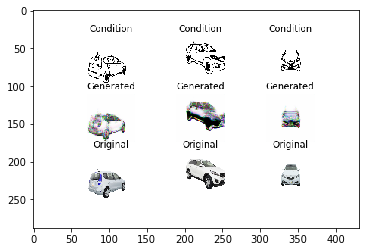

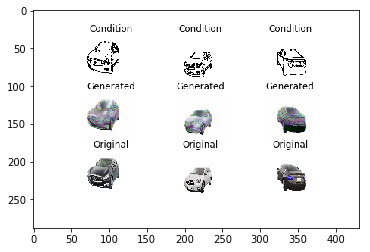

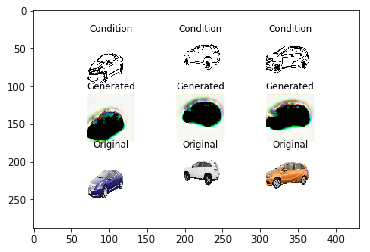

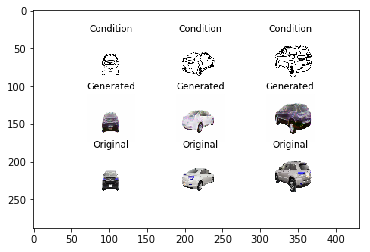

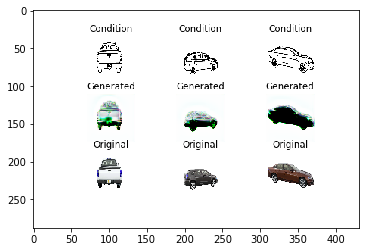

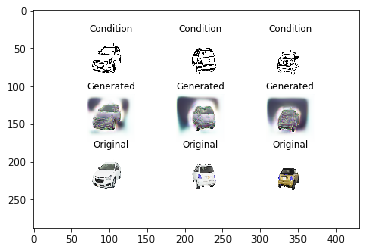

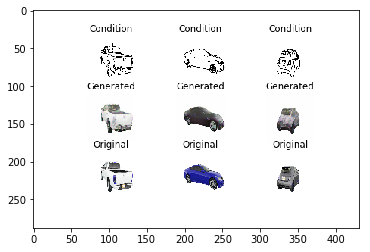

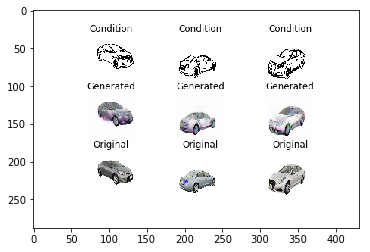

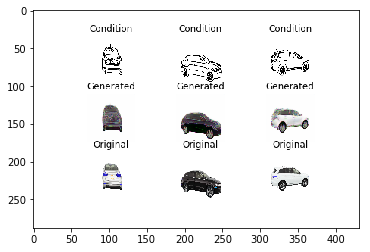

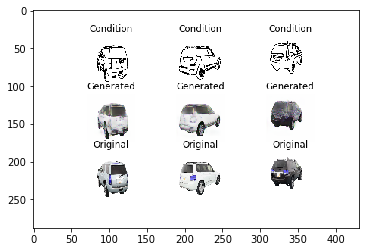

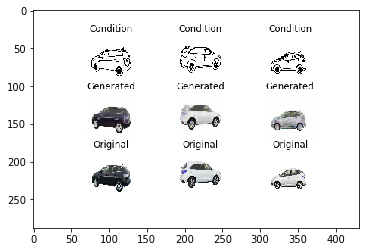

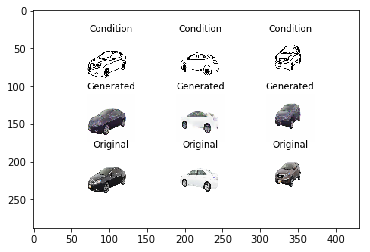

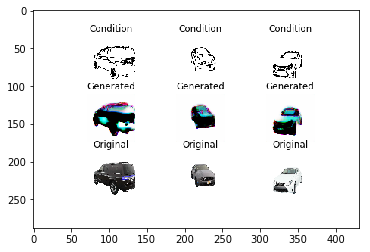

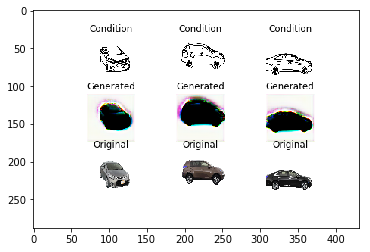

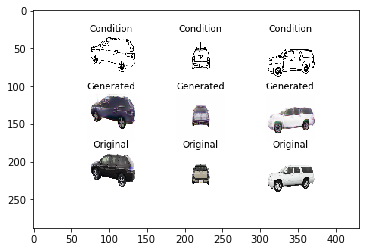

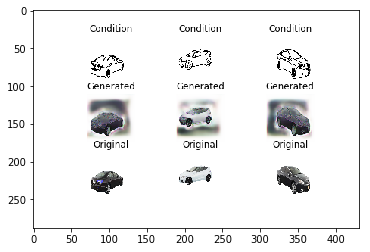

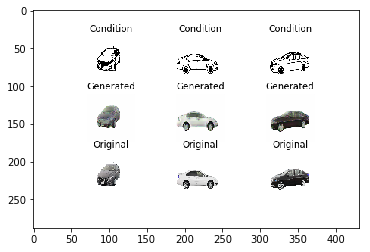

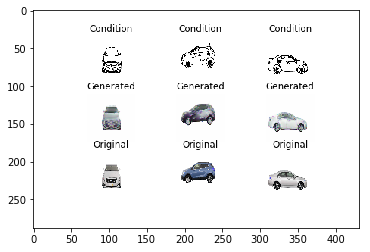

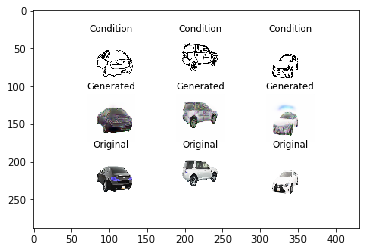

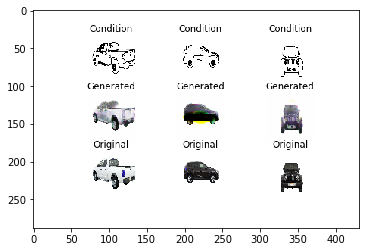

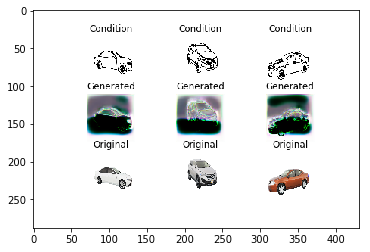

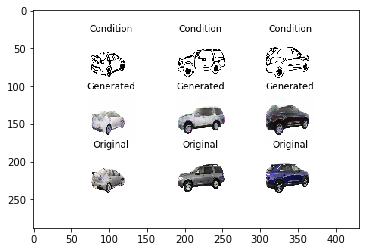

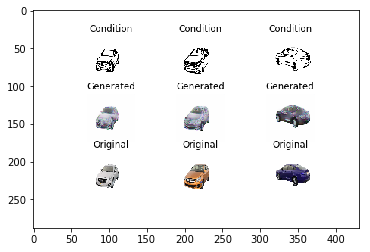

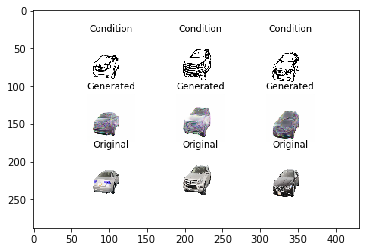

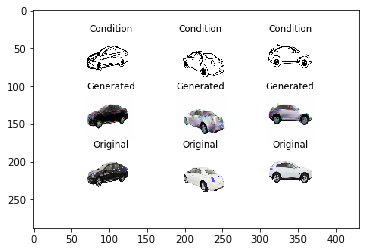

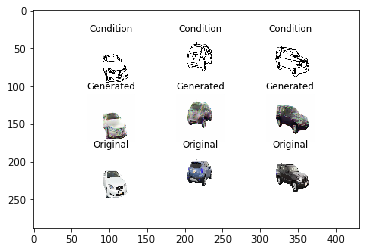

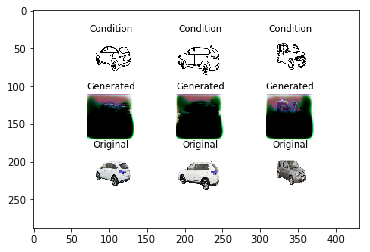

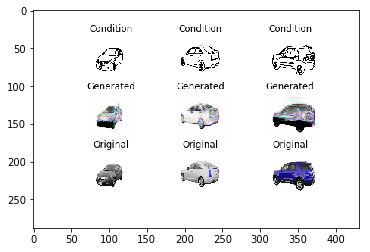

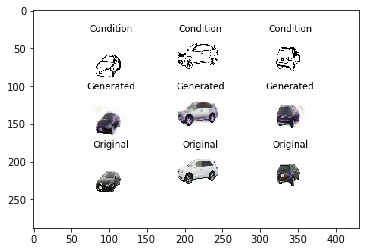

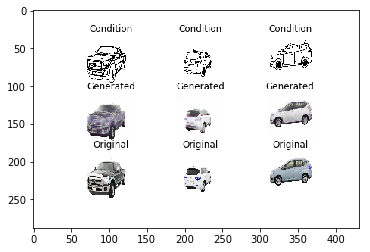

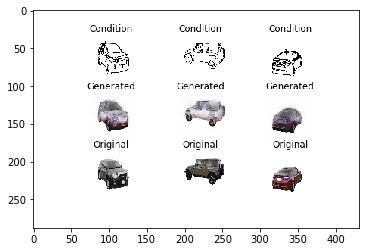

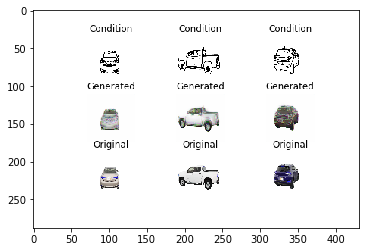

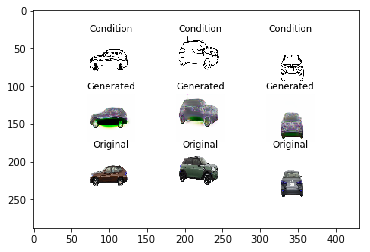

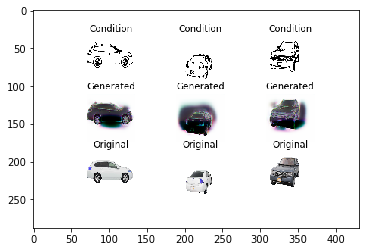

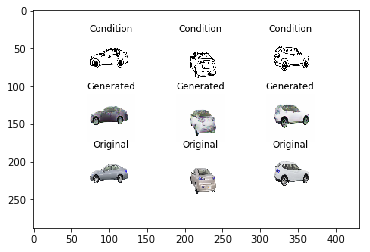

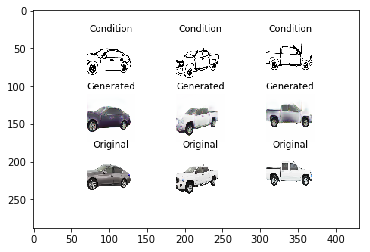

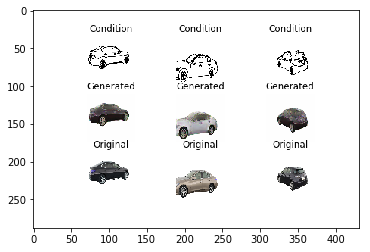

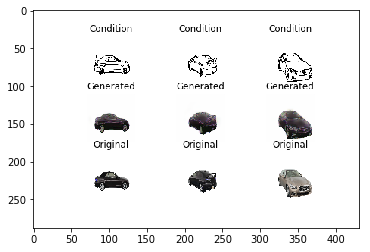

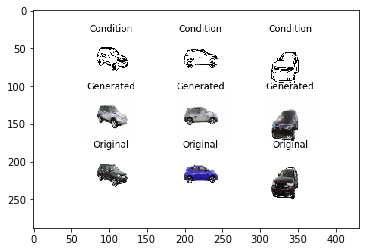

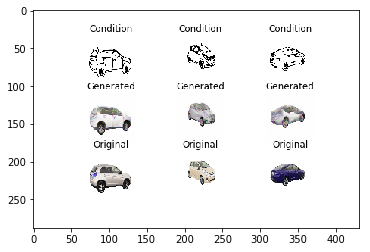

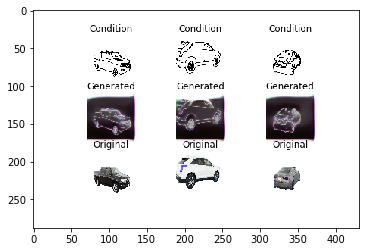

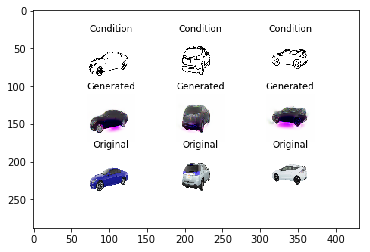

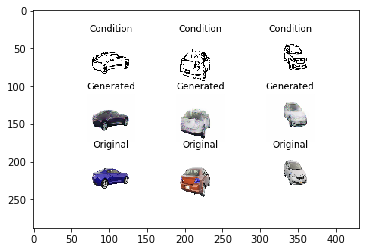

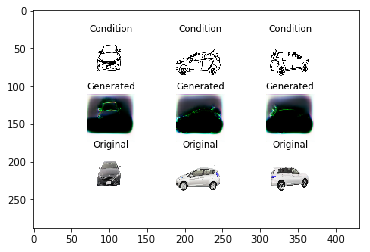

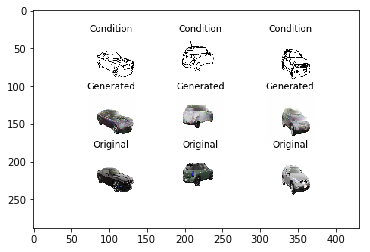

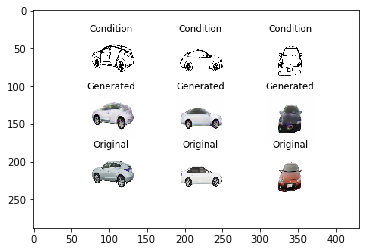

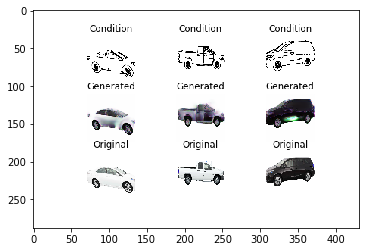

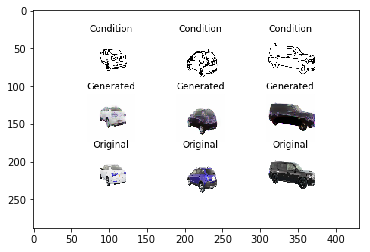

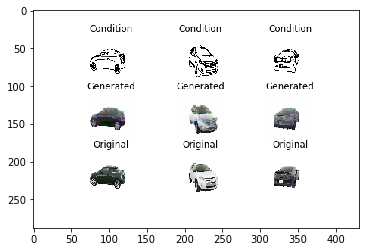

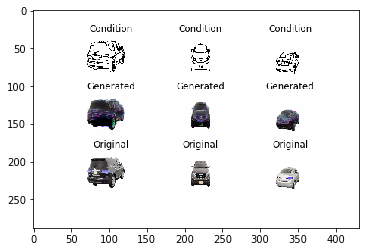

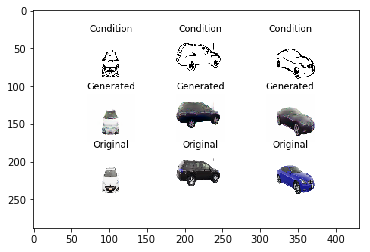

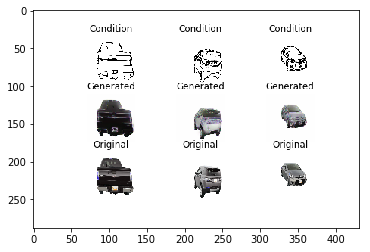

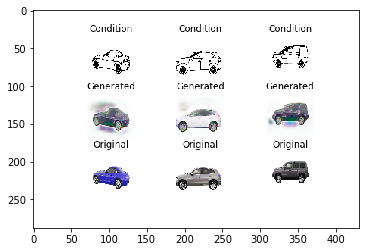

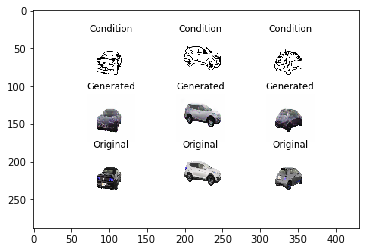

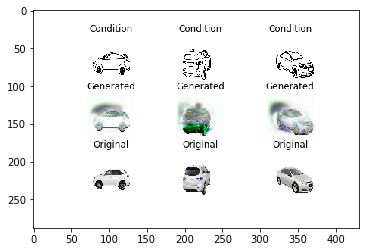

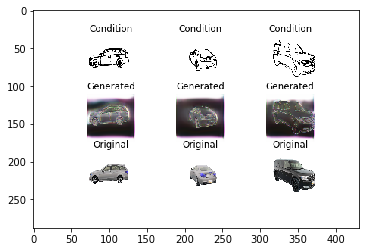

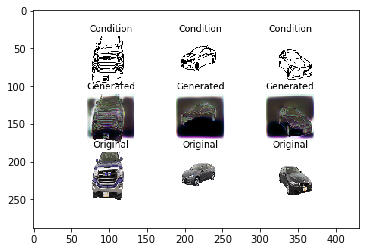

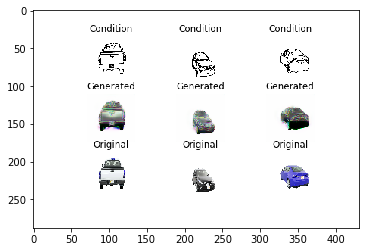

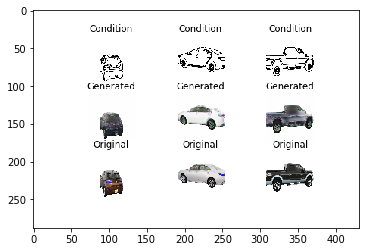

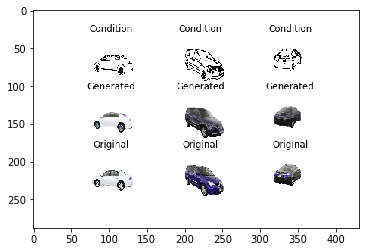

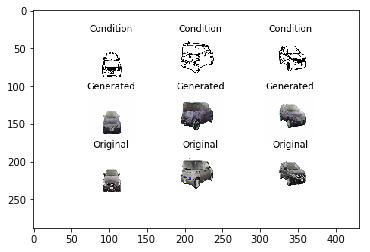

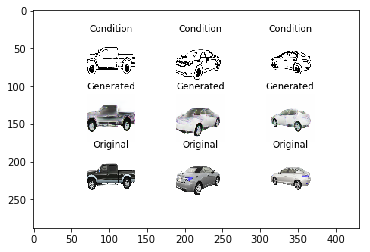

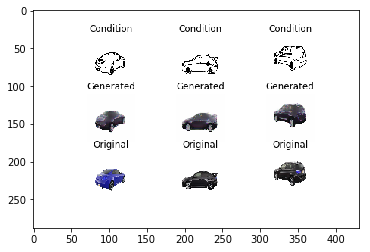

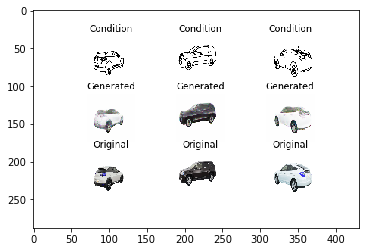

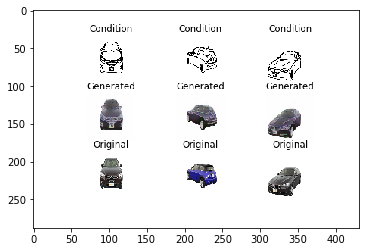

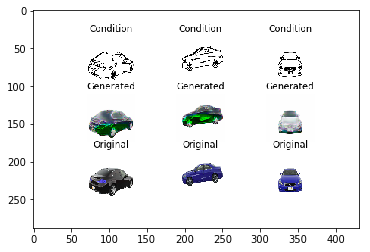

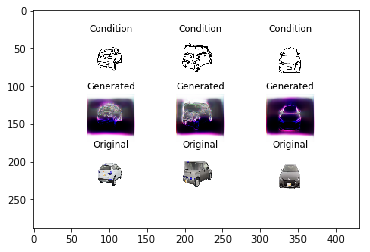

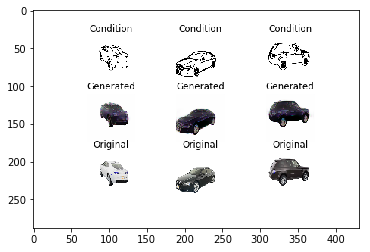

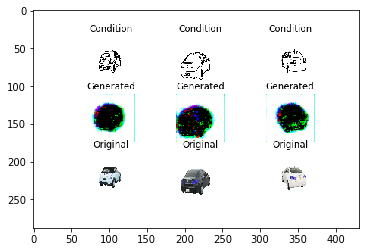

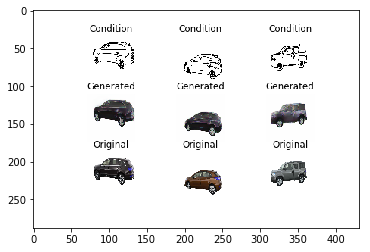

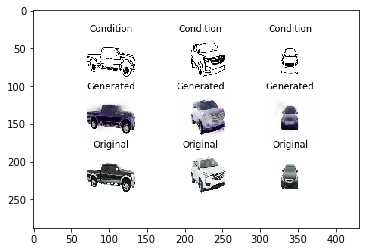

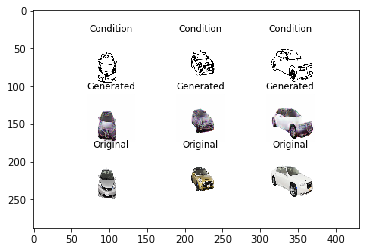

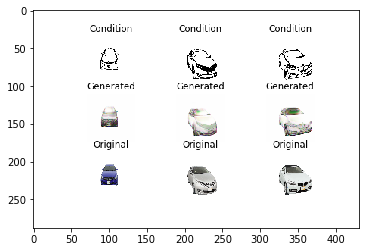

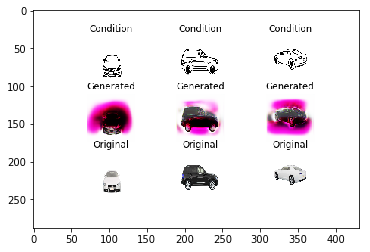

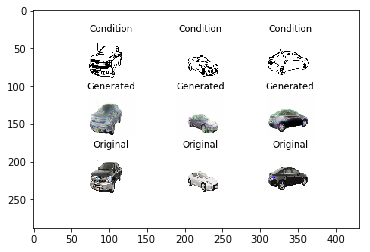

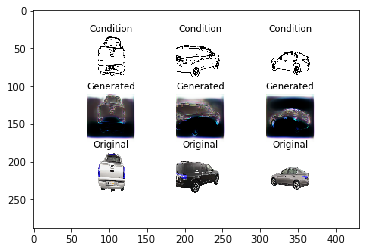

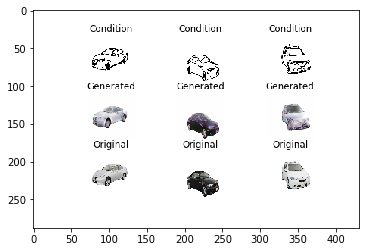

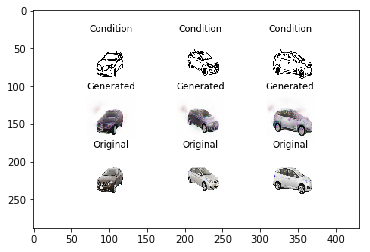

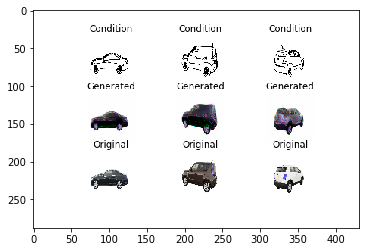

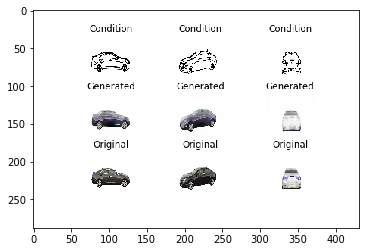

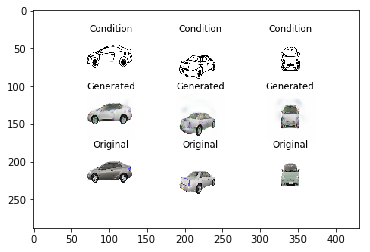

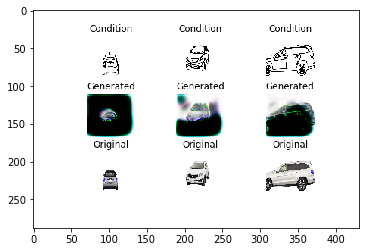

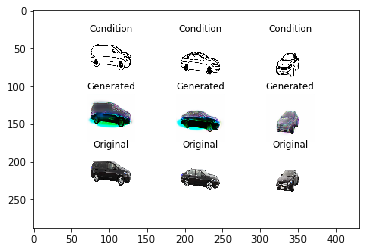

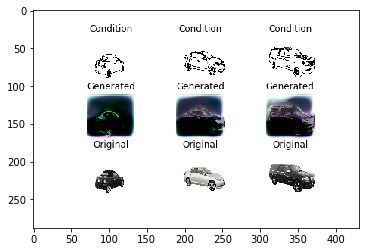

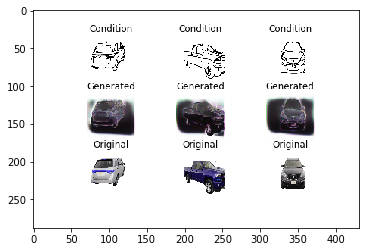

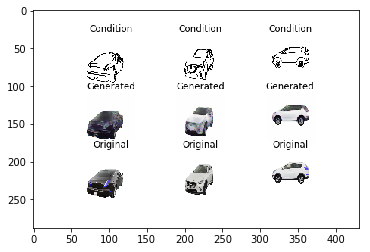

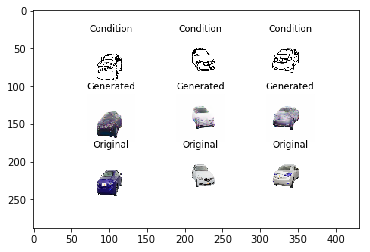

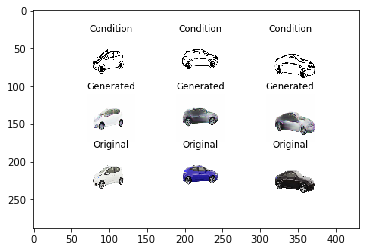

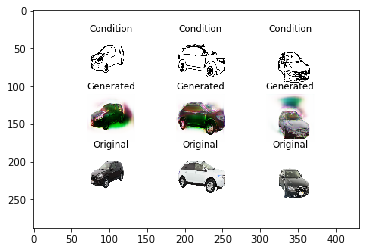

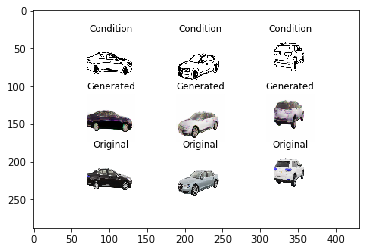

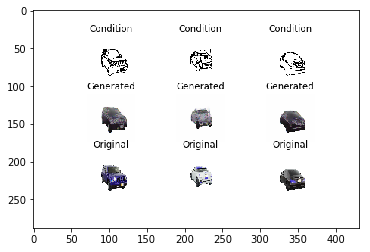

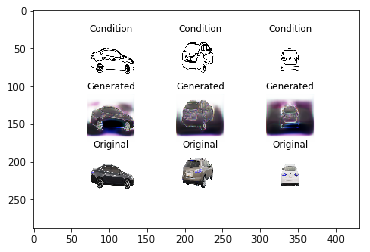

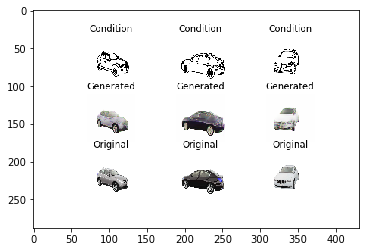

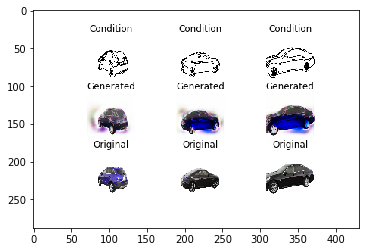

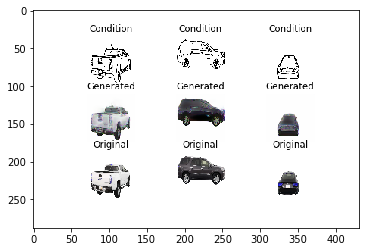

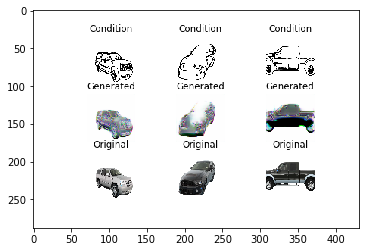

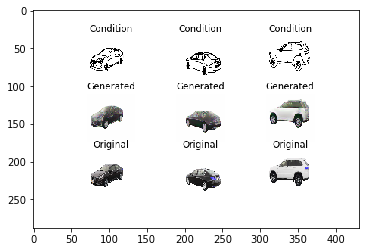

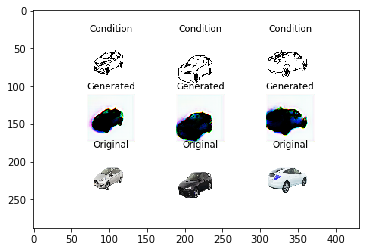

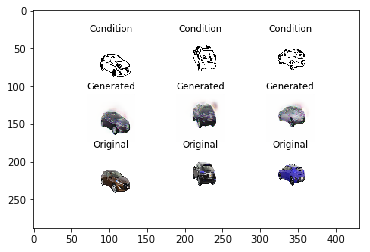

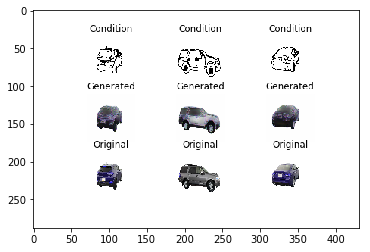

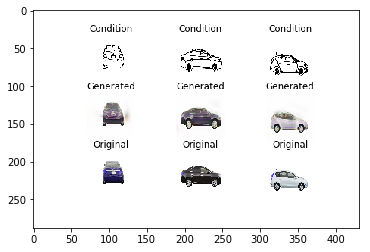

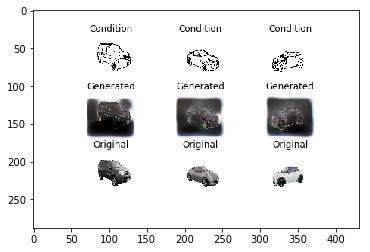

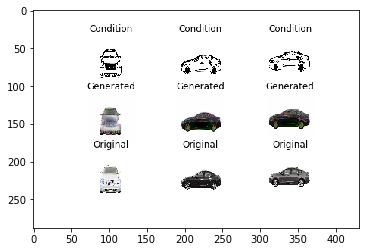

In [40]:


import matplotlib.pyplot as plt
%matplotlib inline

for x in epoch_plot:
    plt.imshow(imread(x))
    plt.show()



In [51]:
imgs_B, imgs_A =  generator_resize(test_input,3, False, H,W,True)
                #generator(train_input,batch_size,False)
                
imgs_A = (imgs_A/127.5)-1
imgs_B = (imgs_B/127.5)-1

#        imgs_A, imgs_B = self.data_loader.load_data(batch_size=3, is_testing=True)
fake_A = pixgan.generator.predict(imgs_B)
fake_A = 0.5 * fake_A + 0.5
imgs_A = 0.5 * imgs_A + 0.5
imgs_B = 0.5 * imgs_B + 0.5


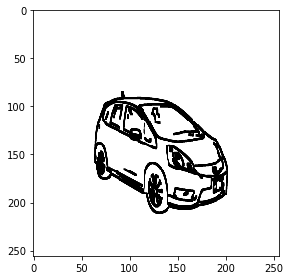

In [52]:
imshow(imgs_B[0])

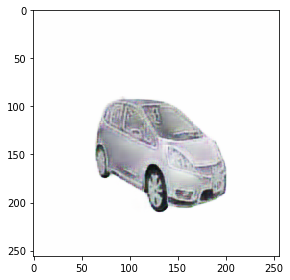

In [53]:
imshow(fake_A[0])

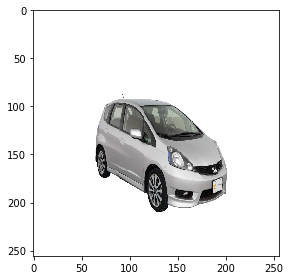

In [54]:
imshow(imgs_A[0])

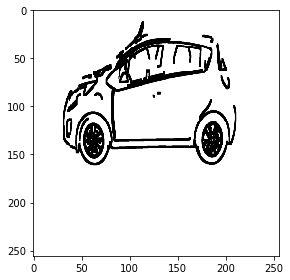

In [55]:
imshow(imgs_B[1])

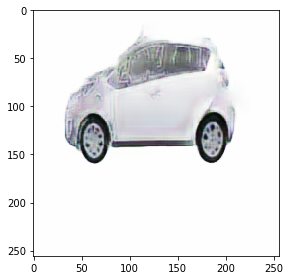

In [56]:
imshow(fake_A[1])

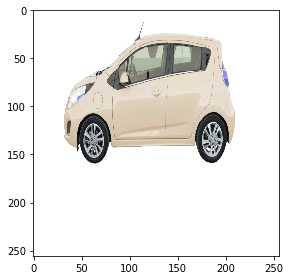

In [58]:
imshow(imgs_A[1])

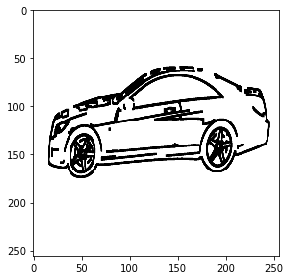

In [59]:
imshow(imgs_B[2])

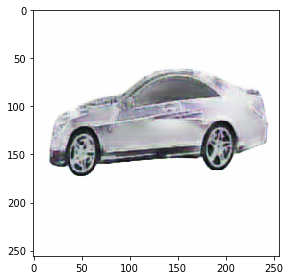

In [60]:
imshow(fake_A[2])

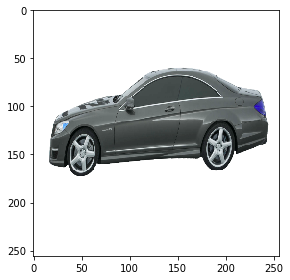

In [62]:
imshow(imgs_A[2])

In [ ]:
#####NO TIENE MALA PINTA!